In [1]:
#  import main packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import pyarrow 

CUDA_VISIBLE_DEVICES=""

# define variables
file_version = ".1"
immo_vis_dir = "../../data/immo_vis/"
parquet_extension = ".parquet"
metropole_appartement_file = "ventes-metropole-appartement" + file_version  + parquet_extension
metropole_maison_file = "ventes-metropole-maison" +  file_version + parquet_extension
metropole_appartement_file_cleaned = metropole_appartement_file + "_step1_clean_" + parquet_extension

dpe_ranking     = ['0','A','B','C','D','E','F','F/G','G','NS','Unknown']
dpe_ranking_num = [0,1,2,3,4,5,6,7,7,0,0]

#  Set plot options
LargePlotActive = False
MediumPlotActive = False
SmallPlotActive = False
HeatMapDisplay = False

# chauffage système
chauffage_sys =["chauf_sys_climatisation","chauf_sys_radiateur","chauf_sys_pompe-chaleur","chauf_sys_chaudiere","chauf_sys_convecteur","chauf_sys_sol","chauf_sys_poele-bois"]
chauffage_mode =["chauffage_mode_individuel","chauffage_mode_collectif","chauffage_mode_central"]
chauffage_energie =["chauf_fioul","chauf_elec","chauf_gaz","chauf_bois"]
chauffage_systems = chauffage_sys + chauffage_mode + chauffage_energie

# expositions
expositions =['expo_has_nord', 'expo_has_sud', 'expo_has_est', 'expo_has_ouest']


# # functions

In [2]:
# functions  

def print_numerical_isna(df) :
    columns = df.select_dtypes(include='number').columns.tolist()
    print (df[columns].isna().sum())

def print_categorial_isna(df) :
    columns = df.select_dtypes(include='category').columns.tolist()
    print (df[columns].isna().sum())     

def load_appartement_file () :
    start_path = Path(immo_vis_dir)
    final_path = start_path / metropole_appartement_file
    return pd.read_parquet(final_path.as_posix())

def save_appartement_file (df) :
    start_path = Path(immo_vis_dir)
    final_path = start_path / metropole_appartement_file_cleaned
    final_path.as_posix
    df.to_parquet(path=final_path.as_posix(),index=True)

def get_numerical_column_names (df) :
    return [ column for column  in df.columns if df[column].dtype not in ["object","category"]]


In [3]:
# chauffage système
def display_heatmap(df, data_selection,target="prix_m2_vente",size=8,annotation=True) : 
    plt.figure(figsize=[size,size])

    data_selection.append(target)
    param = {
        'vmax': 1, 
        'vmin': -1, 
        'cmap': 'coolwarm', 
        'annot': annotation,
        'square': True,           # Cellules carrées
        'fmt': '.2f',            # Format des nombres (3 décimales)
        'cbar_kws': {'label': 'Corrélation'}  # Label de la colorbar
    }
    data = df.loc[:,data_selection].corr()
    display(data[target])
    sns.heatmap(data=data,**param)

# # decode file and display infos

In [4]:
# import appartement file

start_path = Path(immo_vis_dir)
final_path = start_path / metropole_appartement_file
df = load_appartement_file()
nb_rows= df.shape[0]
nb_cols= df.shape[1]

In [5]:
#  print main infos on appartmeent file


print ( f" {metropole_appartement_file} rows {nb_rows} columns {nb_cols}")
print (df.shape)
print (df.columns)
print (df.info())
print (df.describe())



 ventes-metropole-appartement.1.parquet rows 2438201 columns 59
(2438201, 59)
Index(['idannonce', 'type_annonceur', 'typedebien', 'typedetransaction',
       'etage', 'surface', 'surface_terrain', 'nb_pieces', 'prix_bien',
       'prix_maison', 'prix_terrain', 'mensualiteFinance', 'balcon', 'eau',
       'bain', 'dpeL', 'dpeC', 'mapCoordonneesLatitude',
       'mapCoordonneesLongitude', 'annonce_exclusive', 'nb_etages', 'parking',
       'places_parking', 'cave', 'exposition', 'ges_class',
       'annee_construction', 'nb_toilettes', 'nb_terraces', 'videophone',
       'porte_digicode', 'surface_balcon', 'ascenseur', 'nb_logements_copro',
       'charges_copro', 'chauffage_energie', 'chauffage_systeme',
       'chauffage_mode', 'categorie_annonceur', 'logement_neuf', 'duree_int',
       'typedebien_lite', 'date', 'INSEE_COM', 'IRIS', 'CODE_IRIS',
       'TYP_IRIS_x', 'TYP_IRIS_y', 'GRD_QUART', 'UU2010', 'REG', 'DEP',
       'loyer_m2_median_n6', 'nb_log_n6', 'taux_rendement_n6',
      

/home/cv2169/.cache/pypoetry/virtualenvs/immocv-Hc0iPIjN-py3.11/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [6]:
#  print columns modalities
for i in df.columns:
    print(f'modalities  {i} are : ',(df[i].nunique()))

modalities  idannonce are :  2438201
modalities  type_annonceur are :  2
modalities  typedebien are :  2
modalities  typedetransaction are :  3
modalities  etage are :  133
modalities  surface are :  623
modalities  surface_terrain are :  8591
modalities  nb_pieces are :  37
modalities  prix_bien are :  62733
modalities  prix_maison are :  0
modalities  prix_terrain are :  0
modalities  mensualiteFinance are :  3859
modalities  balcon are :  44
modalities  eau are :  37
modalities  bain are :  40
modalities  dpeL are :  19
modalities  dpeC are :  8202
modalities  mapCoordonneesLatitude are :  463889
modalities  mapCoordonneesLongitude are :  613143
modalities  annonce_exclusive are :  3
modalities  nb_etages are :  111
modalities  parking are :  2
modalities  places_parking are :  217
modalities  cave are :  2
modalities  exposition are :  523
modalities  ges_class are :  19
modalities  annee_construction are :  595
modalities  nb_toilettes are :  49
modalities  nb_terraces are :  91
m

In [7]:
#  print comlmns nan values
for i in df.columns:
    print(f' {i} nan values {df[i].isna().sum()}  {(100*df[i].isna().sum()/len(df)):.2f}%')

 idannonce nan values 0  0.00%
 type_annonceur nan values 0  0.00%
 typedebien nan values 0  0.00%
 typedetransaction nan values 0  0.00%
 etage nan values 0  0.00%
 surface nan values 0  0.00%
 surface_terrain nan values 2351341  96.44%
 nb_pieces nan values 0  0.00%
 prix_bien nan values 0  0.00%
 prix_maison nan values 2438201  100.00%
 prix_terrain nan values 2438201  100.00%
 mensualiteFinance nan values 0  0.00%
 balcon nan values 0  0.00%
 eau nan values 0  0.00%
 bain nan values 0  0.00%
 dpeL nan values 0  0.00%
 dpeC nan values 736665  30.21%
 mapCoordonneesLatitude nan values 0  0.00%
 mapCoordonneesLongitude nan values 0  0.00%
 annonce_exclusive nan values 0  0.00%
 nb_etages nan values 790035  32.40%
 parking nan values 2426527  99.52%
 places_parking nan values 1445481  59.28%
 cave nan values 1332104  54.63%
 exposition nan values 0  0.00%
 ges_class nan values 505815  20.75%
 annee_construction nan values 1478612  60.64%
 nb_toilettes nan values 1204709  49.41%
 nb_ter

#  process type_de_bien

In [8]:
#  modify logement_neuf nan according to type de bien

df['logement_neuf'] = df['logement_neuf'].where(df['typedebien'] == "an", df['logement_neuf'].fillna('o'))
df['logement_neuf'] = df['logement_neuf'].where(df['typedebien'] == "a", df['logement_neuf'].fillna('n'))

print (df["logement_neuf"].isna().sum())

# replace an by a
df.loc[:,'typedebien'] ="a"

# process logement neuf as integer
df['logement_neuf'] = df['logement_neuf'].replace(['o','n'],[1,0])

print (df.typedebien.value_counts())
print (df.logement_neuf.value_counts())

print ("************** type de bien ***************************")
print ("keep only type de bien = a , logement neuf as integer 0 1")

0
typedebien
a    2438201
Name: count, dtype: int64
logement_neuf
0    2259929
1     178272
Name: count, dtype: int64
************** type de bien ***************************
keep only type de bien = a , logement neuf as integer 0 1


/tmp/ipykernel_100326/3722005829.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['logement_neuf'] = df['logement_neuf'].replace(['o','n'],[1,0])


## Drop columns that are not relevant

In [9]:
#rendre index=idannonce pour retrouver la ligne initiale
df.set_index('idannonce',drop=True,inplace=True)

#supprimer les colonnes non pertinentes pour les maisons
df.drop(columns=['type_annonceur', 'typedetransaction','typedebien_lite',
       'prix_maison', 'prix_terrain', 'mensualiteFinance',"surface_terrain",
    #    'dpeC', #pas d'information supplémentaire sur dpeC par rapport à dpeL
    #    'date','eau',
       'categorie_annonceur', 'INSEE_COM', 'IRIS', 'duree_int',
       'TYP_IRIS_x', 'TYP_IRIS_y', 'GRD_QUART', 'UU2010', 
       'loyer_m2_median_n6', 'nb_log_n6', 'taux_rendement_n6',
       'loyer_m2_median_n7', 'nb_log_n7', 'taux_rendement_n7'], 
       inplace=True)

## Process prix_m2_vente

In [10]:
# pre-analyse prix de vente au m2
if MediumPlotActive :
    plt.figure(figsize=(22,6))
    plt.subplot(151)
    sns.boxplot(df['prix_m2_vente'])
    plt.subplot(152)
    sns.histplot(df['prix_m2_vente'])
    plt.subplot(153)
    sns.scatterplot (df,x="surface",y="prix_m2_vente")
    plt.show()

df.describe()['prix_m2_vente']


/home/cv2169/.cache/pypoetry/virtualenvs/immocv-Hc0iPIjN-py3.11/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    2438201.00
mean            inf
std             NaN
min            0.02
25%         2777.78
50%         4061.73
75%         5833.33
max             inf
Name: prix_m2_vente, dtype: float64

In [11]:


# remove outliers : 0,2%

colonnes_num_prim = ['surface',  'prix_m2_vente']

# Création du masque en utilisant apply
mask = df[colonnes_num_prim].apply(lambda x: (x >= x.quantile(0.002)) & (x <= x.quantile(0.998))| x.isna()).all(axis=1)
#ne garder que les lignes qui sont entre q=0.005 et q=0.995
df=df[mask]
#Vérification des résultats
df[colonnes_num_prim].describe()

(df['prix_m2_vente']*df['surface']-df['prix_bien']).describe()

if MediumPlotActive :
    plt.figure(figsize=(22,6))
    plt.subplot(151)
    sns.boxplot(df['prix_m2_vente'])
    plt.subplot(152)
    sns.histplot(df['prix_m2_vente'])
    plt.subplot(153)
    sns.scatterplot (df,x="surface",y="prix_m2_vente")
    plt.show()

# 
print ("************** prix_m2_vente : x >= x.quantile(0.002)) & (x <= x.quantile(0.998) ***************************")

************** prix_m2_vente : x >= x.quantile(0.002)) & (x <= x.quantile(0.998) ***************************


In [12]:
import datetime

def display_pandemic ():
    plt.axvline(datetime.datetime(2020, 1,9 ), color='red', linewidth=3, linestyle='-')
    bottom,top = plt.ylim()
    ypos = bottom + (top-bottom)*0.15
    plt.text (datetime.datetime(2019, 6,1 ), ypos,"start pandemic")

    plt.axvspan(datetime.datetime(2020, 3,17), datetime.datetime(2020, 5,11 ), color='red',alpha=0.4)
    plt.axvline(datetime.datetime(2020, 3,17 ), color='red', linewidth=3, linestyle='--')
    plt.axvline(datetime.datetime(2020, 5,11 ), color='red', linewidth=3, linestyle='--')

    plt.axvspan(datetime.datetime(2020, 10,30 ), datetime.datetime(2020,12,15), color='red',alpha=0.4)
    plt.axvline(datetime.datetime(2020, 10,30 ), color='red', linewidth=3, linestyle='--')
    plt.axvline(datetime.datetime(2020, 12,15 ), color='red', linewidth=3, linestyle='--')

    plt.axvspan(datetime.datetime(2021, 4,3 ), datetime.datetime(2021, 5,3 ), color='red',alpha=0.4)
    plt.axvline(datetime.datetime(2021, 4,3 ), color='red', linewidth=3, linestyle='--')
    plt.axvline(datetime.datetime(2021, 5,3 ), color='red', linewidth=3, linestyle='--')

    plt.axvline(datetime.datetime(2023, 1,1 ), color='red', linewidth=3, linestyle='-')
    plt.text (datetime.datetime(2023, 1,1 ), ypos,"end pandemic")

In [13]:
def display_extra_data() :
    plt.axvspan(datetime.datetime(2025, 3,1 ), datetime.datetime(2025, 12,1 ), color='orange',alpha=0.4)

In [14]:
def display_prediction_window() :
    plt.axvspan(datetime.datetime(2024, 7,1 ), datetime.datetime(2025, 12,1 ), color='pink',alpha=0.4)

## Process time series

prix_m2_vente    0
date             0
dtype: int64
prix_m2_vente    float64
date              object
dtype: object
prix_m2_vente           float64
date             datetime64[ns]
dtype: object


/tmp/ipykernel_100326/420779903.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["date"] = pd.to_datetime(df1["date"],format="%Y-%m")


,prix_m2_vente,date
date,,
2025-01-01,4712.364447,2024-12-31 23:59:59.999999744
2025-02-01,4653.598622,2025-02-01 00:00:00.000000000
2025-03-01,4714.943824,2025-03-01 00:00:00.000000000
2025-04-01,4879.409615,2025-04-01 00:00:00.000000000
2025-05-01,4767.797507,2025-05-01 08:00:00.000000000
2025-06-01,4656.185398,2025-05-31 16:00:00.000000000
2025-07-01,4544.573290,2025-07-01 00:00:00.000000000
2025-08-01,4452.751555,2025-08-01 00:00:00.000000000
2025-09-01,4691.698509,2025-09-01 00:00:00.000000000


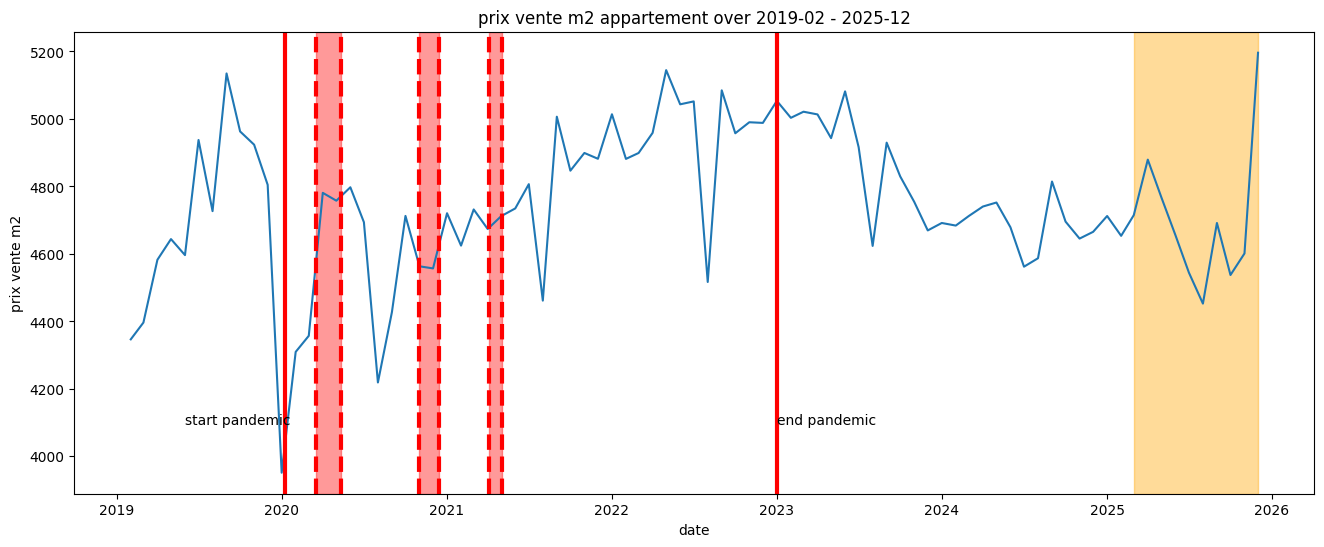

,prix_m2_vente,date
date,,
2019-02-01,4346.828981,2019-02-01 00:00:00.000000000
2019-03-01,4396.564659,2019-03-01 00:00:00.000000000
2019-04-01,4582.680229,2019-04-01 00:00:00.000000000
2019-05-01,4643.971588,2019-05-01 00:00:00.000000000
2019-06-01,4596.453575,2019-06-01 00:00:00.000000000
...,...,...
2025-08-01,4452.751555,2025-08-01 00:00:00.000000000
2025-09-01,4691.698509,2025-09-01 00:00:00.000000000
2025-10-01,4537.504116,2025-10-01 00:00:00.000000000


In [15]:

df1 = df[["prix_m2_vente", "date"]]
print (df1.isna().sum())

print (df1.dtypes)
df1["date"] = pd.to_datetime(df1["date"],format="%Y-%m")
df1 = df1.set_index('date',drop=False)
print (df1.dtypes)
df1 = df1.sort_index(ascending=True)
df2 = df1.resample("MS").mean()
df2 = df2.interpolate()

display(df2.tail(12))

plt.figure(figsize=(16,6))
title = "prix vente m2 appartement over " + df2.index[0].strftime('%Y-%m') + " - " + df2.index[0-1].strftime('%Y-%m')
plt.title (title)
plt.ylabel('prix vente m2')
plt.xlabel('date')
plt.plot(df2.prix_m2_vente)

display_pandemic()

display_extra_data()

plt.show()
display (df2)

## recover inflation rate,  loan rate ...

,date,inflation,taux_livret_A,taux_BCE,taux_pret_20ans
0,2019-02-01,1.3,0.75,-0.4,1.5
1,2019-03-01,1.1,0.75,-0.4,1.5
2,2019-04-01,1.3,0.75,-0.4,1.5
3,2019-05-01,0.9,0.75,-0.4,1.5
4,2019-06-01,1.2,0.75,-0.4,1.5
...,...,...,...,...,...
78,2025-08-01,0.9,1.70,3.0,3.2
79,2025-09-01,1.2,1.70,3.0,3.2
80,2025-10-01,0.9,1.70,3.0,3.2
81,2025-11-01,0.9,1.70,3.0,3.2


date
2019-02-01    2.000649
2019-03-01    2.252385
2019-04-01    3.194404
2019-05-01    3.504628
2019-06-01    3.264117
                ...   
2025-08-01    2.536773
2025-09-01    3.746197
2025-10-01    2.965746
2025-11-01    3.288943
2025-12-01    6.300000
Freq: MS, Name: prix_m2_vente, Length: 83, dtype: float64


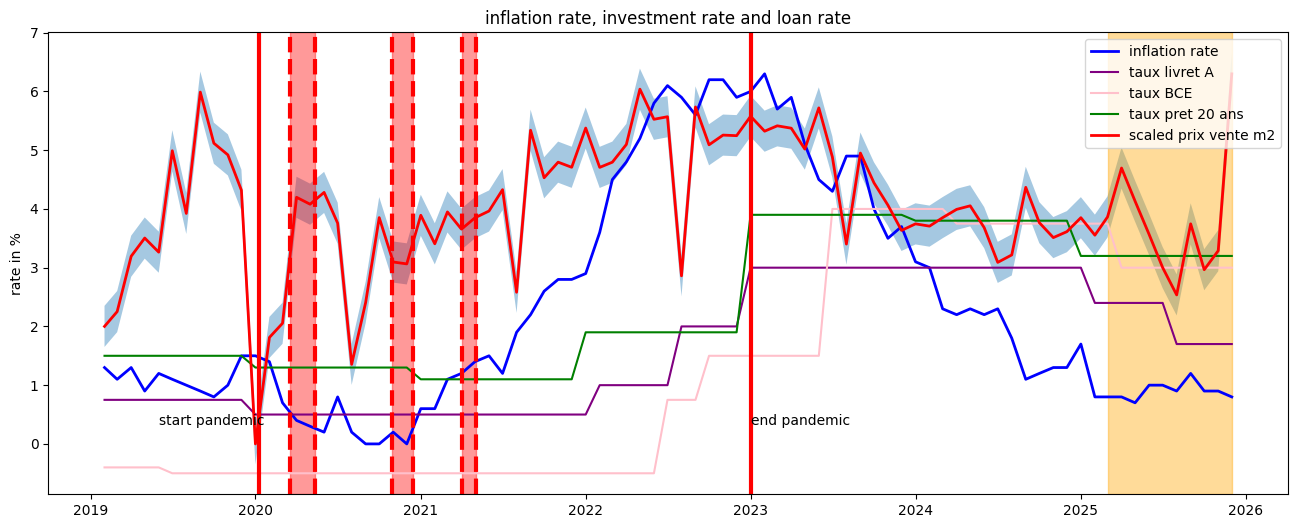

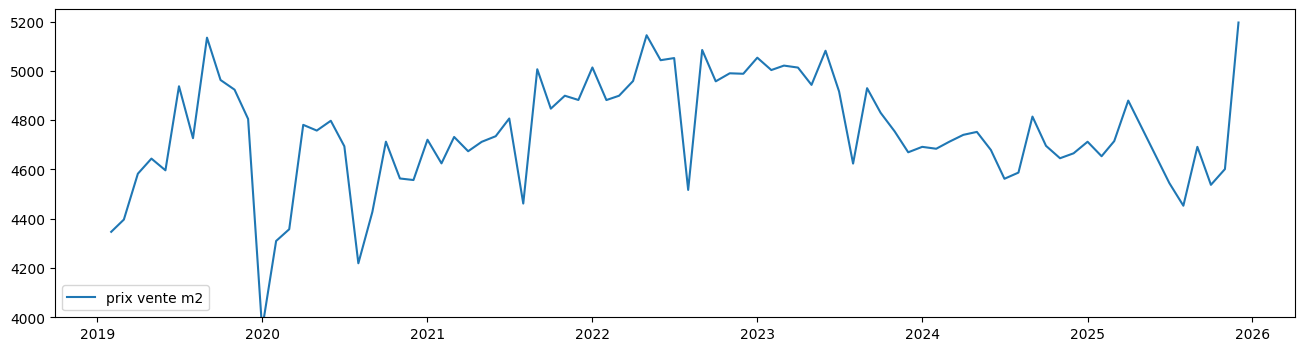

In [16]:

length = 18

start_path = Path(immo_vis_dir)
final_path = start_path / "inflation.csv"
inflation = pd.read_csv(final_path.as_posix())
inflation["date"] = pd.to_datetime(inflation["date"],format="%Y-%m")
display(inflation)

prix_scaled = (df2.prix_m2_vente -df2.prix_m2_vente.min()) / (df2.prix_m2_vente.max()-df2.prix_m2_vente.min())
prix_scaled = prix_scaled*inflation.inflation.max()
print (prix_scaled)


plt.figure(figsize=(16,6))
plt.plot (inflation.date, inflation.inflation,label="inflation rate",linewidth=2,color="blue")
plt.plot (inflation.date, inflation.taux_livret_A,label="taux livret A",color="purple")
plt.plot (inflation.date, inflation.taux_BCE,label="taux BCE",color="pink")
plt.plot (inflation.date, inflation.taux_pret_20ans,label="taux pret 20 ans",color="green")
plt.plot (inflation.date, prix_scaled,label="scaled prix vente m2",linewidth=2,color="red")
plt.title ("inflation rate, investment rate and loan rate")
plt.ylabel("rate in %")

plt.fill_between(inflation.date,prix_scaled -0.35, prix_scaled+0.35, facecolor='C0', alpha=0.4)

display_pandemic()

display_extra_data()
plt.legend()
plt.show()

from scipy.interpolate import  make_interp_spline
mean_price = df2.prix_m2_vente.mean()
xs =np.arange(len(df2.prix_m2_vente))
ys=df2.prix_m2_vente.to_numpy()

cs=make_interp_spline(xs,ys,k=3)

plt.figure(figsize=(16,4))
plt.plot (df2.date,df2.prix_m2_vente,label="prix vente m2")
# plt.plot (df2.date,mean_price+ cs(xs,1), label="smoothed prix vente m2")
plt.ylim((4000,5250))

plt.legend()








In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(actual, predicted, model_name):
    mae = mean_absolute_error(actual,predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mre = np.mean(np.abs((actual - predicted) / actual)) * 100
    r2 = r2_score(actual, predicted)

    
    print(f"\n{model_name} performance  Metrics:")
    print(f"  MAE :  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MRE : {mre:.2f}%")
    print(f"  R2  : {r2:.4f}")

    return mae, rmse, mre, r2

In [18]:

def plot_predictions (forecasts,test_data,length) :


    plt.figure(figsize=(8, 6))
    plt.plot(test_data['ds'],test_data["y"],label="test")
    for key, forecast in forecasts.items() : 
        plt.plot(test_data['ds'],forecast["yhat"].iloc[-length:],label=key)

    plt.ylabel('prix vente m2')
    plt.xlabel('Months')
    plt.xticks(test_data['ds'], rotation=45)

    if 'yhat_lower' in forecast.columns :
        plt.fill_between(test_data['ds'], forecast['yhat_lower'].tail(length), forecast['yhat_upper'].tail(length), 
                        color='orange', alpha=0.15, label='Intervalle de confiance (80%)')
    plt.legend()
    plt.show()

## Prophet Predictions

Importing plotly failed. Interactive plots will not work.


,y,ds
date,,
2019-02-01,4346.828981,2019-02-01 00:00:00.000000000
2019-03-01,4396.564659,2019-03-01 00:00:00.000000000
2019-04-01,4582.680229,2019-04-01 00:00:00.000000000
2019-05-01,4643.971588,2019-05-01 00:00:00.000000000
2019-06-01,4596.453575,2019-06-01 00:00:00.000000000
...,...,...
2025-08-01,4452.751555,2025-08-01 00:00:00.000000000
2025-09-01,4691.698509,2025-09-01 00:00:00.000000000
2025-10-01,4537.504116,2025-10-01 00:00:00.000000000


18:51:11 - cmdstanpy - INFO - Chain [1] start processing
18:51:11 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-02-01,4634.006322,4239.420083,4545.962014,4634.006322,4634.006322,-230.189812,-230.189812,-230.189812,-138.878150,-138.878150,-138.878150,-91.311662,-91.311662,-91.311662,0.0,0.0,0.0,4403.816510
1,2019-03-01,4634.545644,4495.853699,4779.328431,4634.545644,4634.545644,-4.207131,-4.207131,-4.207131,0.434824,0.434824,0.434824,-4.641954,-4.641954,-4.641954,0.0,0.0,0.0,4630.338514
2,2019-04-01,4635.142751,4520.718162,4813.573214,4635.142751,4635.142751,36.638538,36.638538,36.638538,-43.493608,-43.493608,-43.493608,80.132146,80.132146,80.132146,0.0,0.0,0.0,4671.781289
3,2019-05-01,4635.720595,4400.932562,4705.783426,4635.720595,4635.720595,-82.193689,-82.193689,-82.193689,-170.677425,-170.677425,-170.677425,88.483736,88.483736,88.483736,0.0,0.0,0.0,4553.526907
4,2019-06-01,4636.317702,4405.023784,4704.078592,4636.317702,4636.317702,-84.109903,-84.109903,-84.109903,-138.878150,-138.878150,-138.878150,54.768247,54.768247,54.768247,0.0,0.0,0.0,4552.207799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,2025-08-01,4533.104572,4343.377567,4666.107409,4486.714293,4582.535163,-25.399524,-25.399524,-25.399524,175.737298,175.737298,175.737298,-201.136823,-201.136823,-201.136823,0.0,0.0,0.0,4507.705048
79,2025-09-01,4520.324702,4473.760928,4805.831265,4468.856966,4576.395271,119.041591,119.041591,119.041591,0.434824,0.434824,0.434824,118.606767,118.606767,118.606767,0.0,0.0,0.0,4639.366293
80,2025-10-01,4507.957085,4261.294172,4587.947492,4452.144966,4570.464188,-90.076751,-90.076751,-90.076751,-147.837364,-147.837364,-147.837364,57.760613,57.760613,57.760613,0.0,0.0,0.0,4417.880334
81,2025-11-01,4495.177215,4190.806935,4496.840556,4435.128147,4565.035057,-149.510077,-149.510077,-149.510077,-170.677425,-170.677425,-170.677425,21.167348,21.167348,21.167348,0.0,0.0,0.0,4345.667138



Prophet performance  Metrics:
  MAE :  203.20
  RMSE: 296.54
  MRE : 4.27%
  R2  : -2.4765


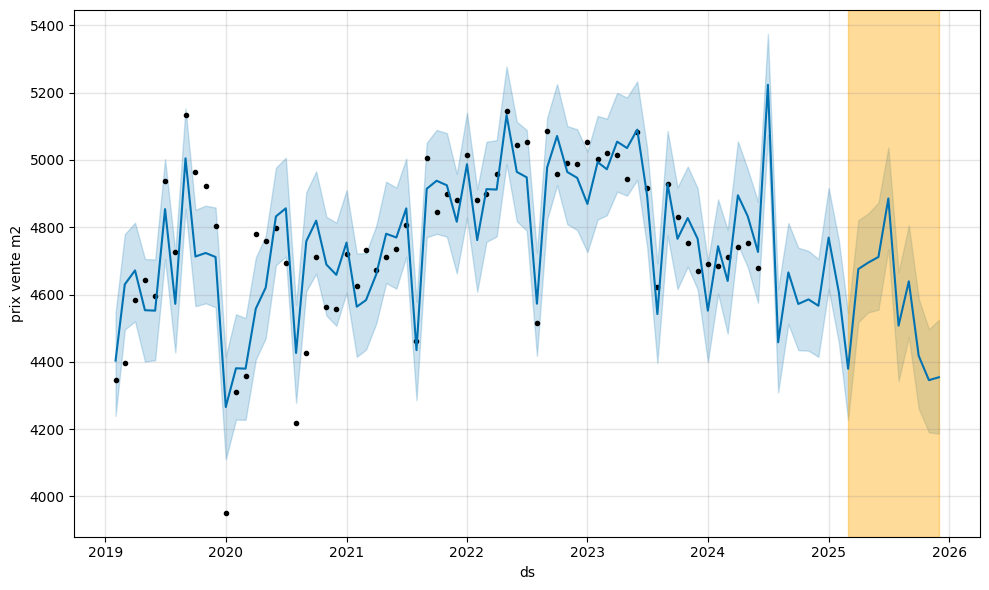

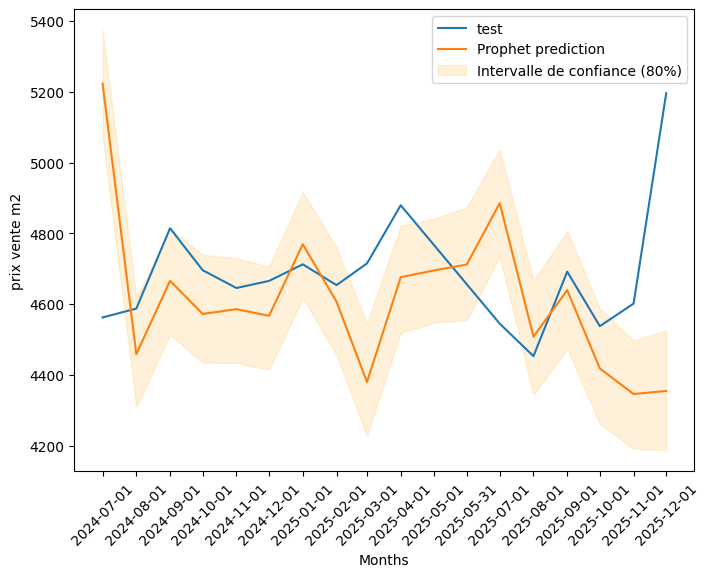

In [19]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
length = 18
df3 = df2.rename(columns={"date" : "ds","prix_m2_vente":"y"})
display(df3)

train_data = df3[:-length]
test_data = df3[-length:]

model = Prophet (changepoint_prior_scale=0.05)
model.add_seasonality(name='monthly', period=12, fourier_order=5)

model.fit (train_data)

future = model.make_future_dataframe(periods=length,freq="MS")

forecast = model.predict(future)
display(forecast)

model.plot(forecast, ylabel = "prix vente m2")
display_extra_data()

y_true = test_data['y'].values
y_pred = forecast['yhat'][-length:].values

mae, rmse, mre, r2 = calculate_metrics(y_true,y_pred,"Prophet")

plt.show()

forecasts = {"Prophet prediction": forecast}
plot_predictions(forecasts,test_data,length)


In [20]:
df3 = df2.rename(columns={"date" : "ds","prix_m2_vente":"y"})
df3 = pd.merge(df3,inflation,left_index=True,right_on="date")
df3.set_index(df2.index,inplace=True)
df3.drop("date",axis=1,inplace=True)

length = 18

display(df3)
print (df3.columns)


,y,ds,inflation,taux_livret_A,taux_BCE,taux_pret_20ans
date,,,,,,
2019-02-01,4346.828981,2019-02-01 00:00:00.000000000,1.3,0.75,-0.4,1.5
2019-03-01,4396.564659,2019-03-01 00:00:00.000000000,1.1,0.75,-0.4,1.5
2019-04-01,4582.680229,2019-04-01 00:00:00.000000000,1.3,0.75,-0.4,1.5
2019-05-01,4643.971588,2019-05-01 00:00:00.000000000,0.9,0.75,-0.4,1.5
2019-06-01,4596.453575,2019-06-01 00:00:00.000000000,1.2,0.75,-0.4,1.5
...,...,...,...,...,...,...
2025-08-01,4452.751555,2025-08-01 00:00:00.000000000,0.9,1.70,3.0,3.2
2025-09-01,4691.698509,2025-09-01 00:00:00.000000000,1.2,1.70,3.0,3.2
2025-10-01,4537.504116,2025-10-01 00:00:00.000000000,0.9,1.70,3.0,3.2


Index(['y', 'ds', 'inflation', 'taux_livret_A', 'taux_BCE', 'taux_pret_20ans'], dtype='object')


18:51:11 - cmdstanpy - INFO - Chain [1] start processing


18:51:11 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,taux_livret_A,taux_livret_A_lower,taux_livret_A_upper,taux_pret_20ans,taux_pret_20ans_lower,taux_pret_20ans_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-07-01,4830.333515,4581.343725,4990.709467,4830.333515,4830.333515,-37.850430,-37.850430,-37.850430,-141.558081,...,-195.060544,-195.060544,-195.060544,108.239057,108.239057,108.239057,0.0,0.0,0.0,4792.483085
1,2024-08-01,4832.278541,4422.005039,4827.710006,4832.278540,4832.278542,-197.897970,-197.897970,-197.897970,-179.007404,...,-195.060544,-195.060544,-195.060544,108.239057,108.239057,108.239057,0.0,0.0,0.0,4634.380571
2,2024-09-01,4834.223566,4387.919388,4799.303371,4834.223564,4834.223568,-236.189956,-236.189956,-236.189956,-231.436458,...,-195.060544,-195.060544,-195.060544,108.239057,108.239057,108.239057,0.0,0.0,0.0,4598.033611
3,2024-10-01,4836.105849,4308.962350,4710.045004,4836.105846,4836.105853,-320.111502,-320.111502,-320.111502,-223.946593,...,-195.060544,-195.060544,-195.060544,108.239057,108.239057,108.239057,0.0,0.0,0.0,4515.994347
4,2024-11-01,4838.050875,4335.922156,4759.639284,4838.050869,4838.050880,-295.462062,-295.462062,-295.462062,-216.456728,...,-195.060544,-195.060544,-195.060544,108.239057,108.239057,108.239057,0.0,0.0,0.0,4542.588812



=== Model Performance with inflation rate, investment rate and loan rate ===

Prophet with inflation and loan rates performance  Metrics:
  MAE :  151.99
  RMSE: 195.87
  MRE : 3.21%
  R2  : -0.5168


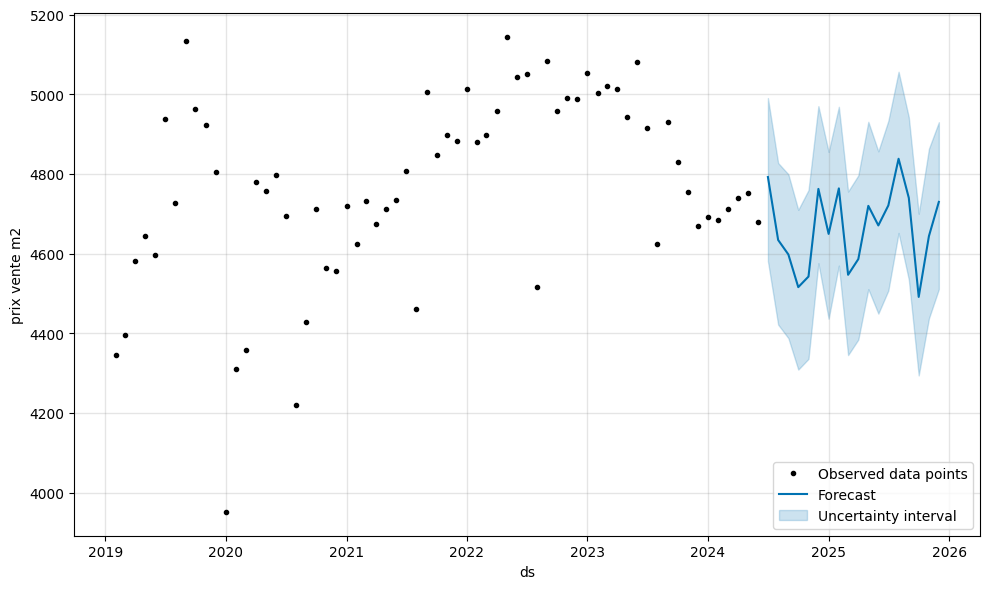

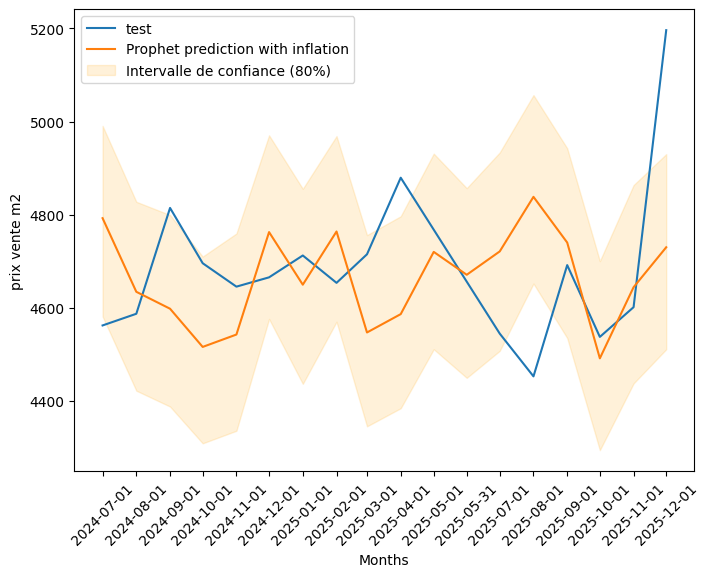

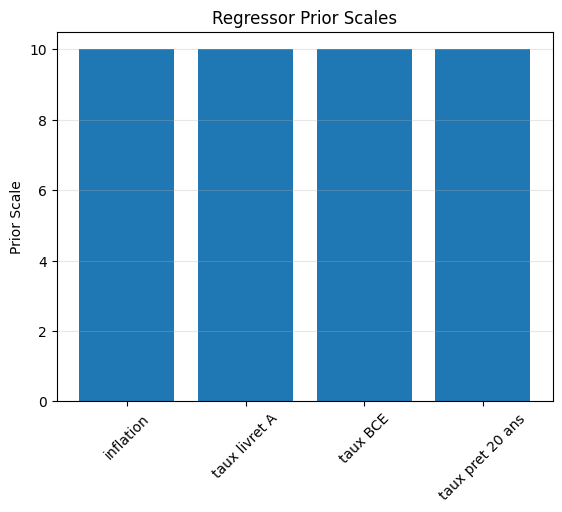

In [21]:
from prophet import Prophet

df_train = df3[:-length]
df_test = df3[-length:]


model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive',
    changepoint_prior_scale=0.05
)

model.add_seasonality(name='monthly', period=12, fourier_order=5)

model.add_regressor('inflation')
model.add_regressor('taux_livret_A')
model.add_regressor('taux_BCE')
model.add_regressor('taux_pret_20ans')

attributes = ['ds', 'y', 'inflation','taux_livret_A','taux_BCE','taux_pret_20ans']
local_frame = df_train[attributes]
model.fit (local_frame)

future = model.make_future_dataframe(periods=length,freq="MS")
future = df_test[attributes].copy()

forecast1 = model.predict(future)
display(forecast1.head(5))

y_true = test_data['y'].values
y_pred = forecast1['yhat'][-length:].values

print("\n=== Model Performance with inflation rate, investment rate and loan rate ===")
mae_rates, rmse_rates, mre_rates, r2_rates = calculate_metrics(y_true,y_pred,"Prophet with inflation and loan rates")


model.plot(forecast1, ylabel = "prix vente m2",plot_cap=True)
plt.legend()
plt.show()

forecasts = {"Prophet prediction with inflation": forecast1}
plot_predictions(forecasts,test_data,length)

regressor_coefficients = {
    'inflation': model.extra_regressors['inflation']['prior_scale'],
    'taux livret A': model.extra_regressors['taux_livret_A']['prior_scale'],
    'taux BCE': model.extra_regressors['taux_BCE']['prior_scale'],
    'taux pret 20 ans': model.extra_regressors['taux_pret_20ans']['prior_scale']
}
plt.bar(regressor_coefficients.keys(), regressor_coefficients.values())
plt.ylabel('Prior Scale')
plt.title('Regressor Prior Scales')
plt.tick_params(axis='x', rotation=45)
plt.grid(True, alpha=0.3, axis='y')



3. Exponential Smoothing (Holt-Winters) Forecast

ExponentialSmoothing with inflation and loan rates performance  Metrics:
  MAE :  135.86
  RMSE: 179.19
  MRE : 2.86%
  R2  : -0.2693


,yhat
2024-07-01,4736.171419
2024-08-01,4364.542951
2024-09-01,4771.929692
2024-10-01,4717.435181
2024-11-01,4682.280506
2024-12-01,4635.766106
2025-01-01,4540.582389
2025-02-01,4554.351172
2025-03-01,4598.376352
2025-04-01,4703.779267


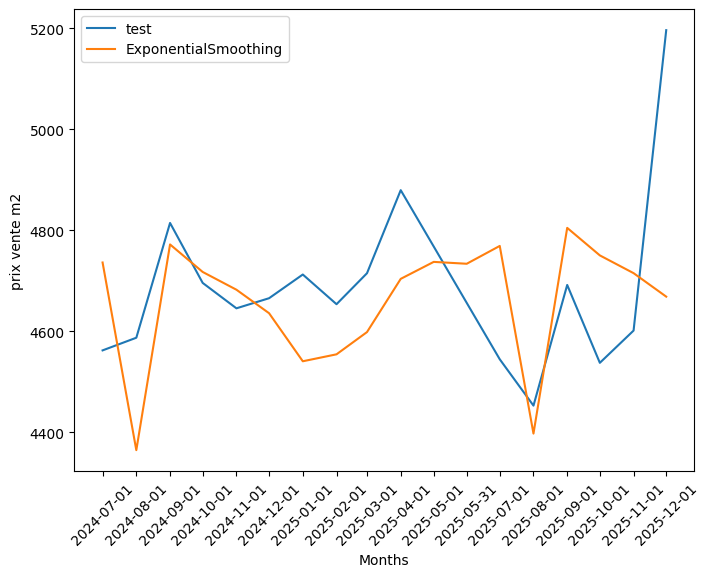

In [22]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

print("\n" + "=" * 50)
print("3. Exponential Smoothing (Holt-Winters) Forecast")
print("=" * 50)

df_train = df3[:-length]
df_test = df3[-length:]

hw_model = ExponentialSmoothing(
    df_train['y'],
    trend='add',
    seasonal='add'
)
hw_fit = hw_model.fit()
hw_pred = hw_fit.forecast(steps=len(df_test))

mae_exp, rmse_exp, mre_exp, r2_exp = calculate_metrics(y_true,hw_pred,"ExponentialSmoothing with inflation and loan rates")
hw_pred = hw_pred.to_frame(name='yhat')
display(hw_pred)

forecasts = {"ExponentialSmoothing": hw_pred}
plot_predictions(forecasts,test_data,length)



# LSTM prediction

In [48]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
def create_sequences(data, lookback=30):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback, :])
        y.append(data[i+lookback, 0])  # target = y
    return np.array(X), np.array(y)

def prepare_lstm_data(df, features, lookback=30):
    """Prepare data for LSTM with multiple features"""
    
    # Normalize data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[features])
    
    # create the data
    X,y = create_sequences(scaled_data,lookback)

    return X, y, scaler

In [49]:


def prepare_lstm_data(df, features, lookback=30):
    """Prepare data for LSTM with multiple features"""
    
    # Normalize data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[features])
    
    # create the data
    X,y = create_sequences(scaled_data,lookback)

    return X, y, scaler

In [53]:

from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

def lstm_forecast(df, features, length= 0, lookback=30):
    """Forecast using LSTM neural network"""
    print("\n" + "=" * 50)
    print("LSTM NEURAL NETWORK FORECASTING")
    print("=" * 50)
    
    # Prepare data
    X, y, scaler = prepare_lstm_data(df, features, lookback)

    with tf.device('/cpu:0'):
        X = tf.convert_to_tensor(X, np.float32)
        y = tf.convert_to_tensor(y, np.float32)
        
    # Split data
    if length == 0 :
       train_size  = int(len(X) * 0.8)
    else :
        train_size = -length
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
 
    

    # model = Sequential([
    #     LSTM(64, return_sequences=True, input_shape=(lookback, X.shape[2])),
    #     Dropout(0.2),
    #     LSTM(32),
    #     Dense(1)
    #     ])
    
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, 
             input_shape=(lookback, X.shape[2])),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])

    model.compile(
        optimizer="adam",
        loss="mse",
        metrics =['mae']
    )

    model.summary()

    
    # Train model
    print("Training LSTM model...")
    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=32,
        validation_split=0.1,
        verbose=0
    )
    
    # Make predictions on test set
    pred_scaled = model.predict(X_test)

    # Re-scale predictions
    dummy = np.zeros((len(pred_scaled), len(features)))
    dummy[:, 0] = pred_scaled[:, 0]

    y_pred = scaler.inverse_transform(dummy)[:, 0]

    
    return model, X_test, y_test, y_pred, history


,y,ds,inflation,taux_livret_A,taux_BCE,taux_pret_20ans
date,,,,,,
2019-02-01,4346.828981,2019-02-01 00:00:00.000000000,1.3,0.75,-0.4,1.5
2019-03-01,4396.564659,2019-03-01 00:00:00.000000000,1.1,0.75,-0.4,1.5
2019-04-01,4582.680229,2019-04-01 00:00:00.000000000,1.3,0.75,-0.4,1.5
2019-05-01,4643.971588,2019-05-01 00:00:00.000000000,0.9,0.75,-0.4,1.5
2019-06-01,4596.453575,2019-06-01 00:00:00.000000000,1.2,0.75,-0.4,1.5
...,...,...,...,...,...,...
2025-08-01,4452.751555,2025-08-01 00:00:00.000000000,0.9,1.70,3.0,3.2
2025-09-01,4691.698509,2025-09-01 00:00:00.000000000,1.2,1.70,3.0,3.2
2025-10-01,4537.504116,2025-10-01 00:00:00.000000000,0.9,1.70,3.0,3.2



LSTM NEURAL NETWORK FORECASTING


/home/cv2169/.cache/pypoetry/virtualenvs/immocv-Hc0iPIjN-py3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_34 (LSTM)                  │ (None, 30, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,701 (127.74 KB)

 Trainable params: 32,701 (127.74 KB)

 Non-trainable params: 0 (0.00 B)

Training LSTM model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step

LSTM prediction model performance  Metrics:
  MAE :  112.76
  RMSE: 159.29
  MRE : 2.37%
  R2  : -0.0031


array([4687.44434106, 4678.86044301, 4671.37425595, 4666.33024582,
       4662.73753484, 4660.05327687, 4659.21619435, 4660.87336995,
       4664.71825176, 4669.74913031, 4677.95028363, 4686.94956987,
       4695.33263636, 4700.91852814, 4705.20224211, 4712.13682866,
       4717.52930787, 4722.91503581])

<tf.Tensor: shape=(18,), dtype=float32, numpy=
array([0.49054483, 0.51067305, 0.693289  , 0.59787685, 0.5574773 ,
       0.57353306, 0.6112376 , 0.5640246 , 0.61330986, 0.7454431 ,
       0.655773  , 0.56610286, 0.47643274, 0.4026624 , 0.5946344 ,
       0.4707533 , 0.52205443, 1.        ], dtype=float32)>

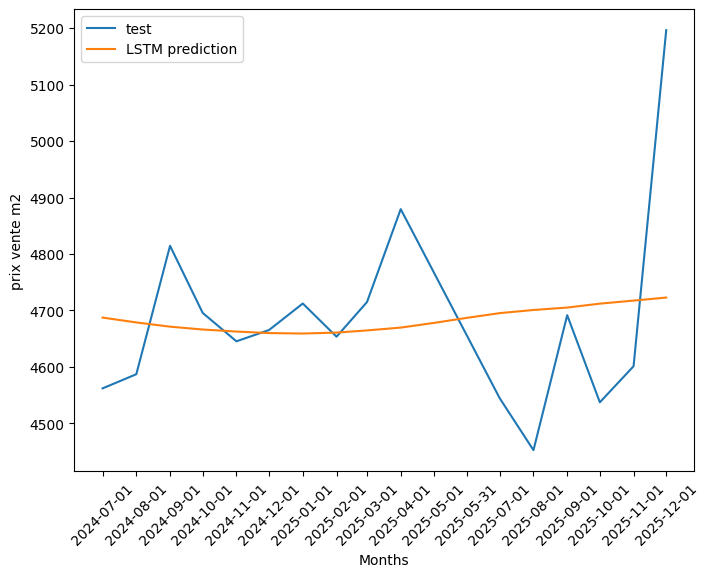

In [54]:
display(df3)

features = ['y', 'inflation', 'taux_livret_A', 'taux_BCE', 'taux_pret_20ans']

tf.config.set_visible_devices([], '')

model, X_test, y_test, y_pred, history = lstm_forecast(df=df3,features=features,length=length,lookback=30)

data = {
    'time' :  df3.index[-len(y_pred)],
    'yhat' : y_pred
}


mae_lstm, rmse_lstm, mre_lstm, r2_lstm = calculate_metrics(y_true,y_pred,"LSTM prediction model")

y_pred_lstm = pd.DataFrame(data)

display(y_pred)
display(y_test)

forecasts = {"LSTM prediction": y_pred_lstm}
plot_predictions(forecasts,test_data[-len(y_pred_lstm):],length)

# Prediction analysis summary


=== Prophet Performance ===
MAE: 203.20
RMSE: 296.54
R² Score: -2.4765

=== Prophet Performance with inflation rate, investment rate and loan rate ===
MAE: 151.99
RMSE: 195.87
R² Score: -0.5168

=== LSTM prediction  ===
MAE: 112.76
RMSE: 159.29
R² Score: -0.0031

=== Exponetial smoothing Performance  ===
MAE: 135.86
RMSE: 179.19
R² Score: -0.2693


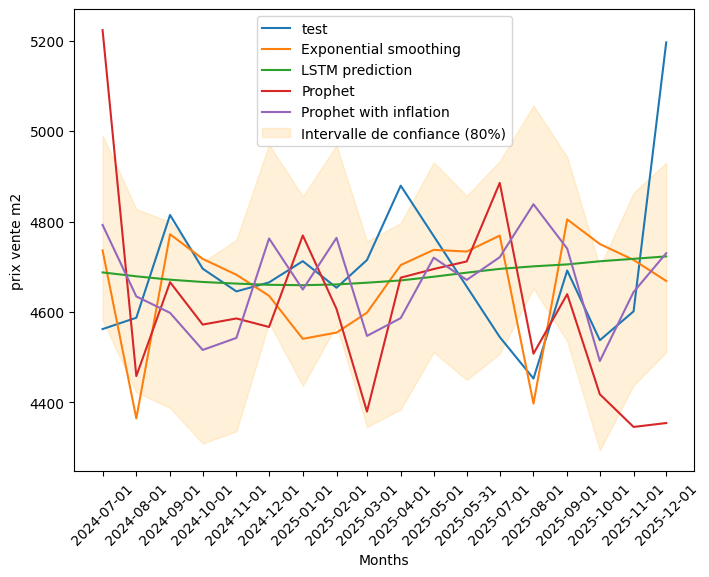

In [55]:

print("\n=== Prophet Performance ===")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


print("\n=== Prophet Performance with inflation rate, investment rate and loan rate ===")
print(f"MAE: {mae_rates:.2f}")
print(f"RMSE: {rmse_rates:.2f}")
print(f"R² Score: {r2_rates:.4f}")

print("\n=== LSTM prediction  ===")
print(f"MAE: {mae_lstm:.2f}")
print(f"RMSE: {rmse_lstm:.2f}")
print(f"R² Score: {r2_lstm:.4f}")

print("\n=== Exponetial smoothing Performance  ===")
print(f"MAE: {mae_exp:.2f}")
print(f"RMSE: {rmse_exp:.2f}")
print(f"R² Score: {r2_exp:.4f}")


forecasts = {"Exponential smoothing": hw_pred, "LSTM prediction" : y_pred_lstm, "Prophet": forecast, "Prophet with inflation" : forecast1}
plot_predictions(forecasts,test_data,length)